In [50]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import preprocess_input
from scipy.linalg import sqrtm

def load_real_images(dataset, num_samples=10000):
    """Loads real images from MNIST, Fashion-MNIST, or CIFAR-10."""
    if dataset == "mnist":
        (x_train, _), _ = tf.keras.datasets.mnist.load_data()
        x_train = np.expand_dims(x_train, axis=-1)  # Add channel dimension
    elif dataset == "fashion-mnist":
        (x_train, _), _ = tf.keras.datasets.fashion_mnist.load_data()
        x_train = np.expand_dims(x_train, axis=-1)  # Add channel dimension
    elif dataset == "cifar10":
        (x_train, _), _ = tf.keras.datasets.cifar10.load_data()
    else:
        raise ValueError(f"Unknown dataset: {dataset}")

    x_train = x_train.astype(np.float32) / 255.0
    idx = np.random.choice(len(x_train), num_samples, replace=False)
    return x_train[idx]
import numpy as np
import tensorflow as tf
from scipy.linalg import sqrtm
from tensorflow.keras.applications.inception_v3 import preprocess_input

def calculate_fid_score(generated_images, dataset, classifier, batch_size=32):
    """
    Computes the Fréchet Inception Distance (FID) between generated and real images.

    Parameters:
        generated_images (numpy.ndarray): Generated images with shape (N, H, W, C).
        dataset (str): One of ["mnist", "fashion-mnist", "cifar10"].
        classifier (tf.keras.Model): Model for feature extraction.
                                   For CIFAR-10, use InceptionV3 (include_top=False, pooling="avg").
        batch_size (int): Batch size for inference.

    Returns:
        float: FID score (lower is better).
    """
    # Load real images for the chosen dataset
    real_images = load_real_images(dataset)

    # Determine expected input shape
    input_shape = classifier.input.shape.as_list()  # e.g., [None, 299, 299, 3] or [None, 28, 28, 1]
    print(f"INPUT SHAPE: {input_shape}")
    expected_height, expected_width, expected_channels = input_shape[1], input_shape[2], input_shape[3]

    # Set defaults if input shape is undefined
    if expected_height is None or expected_width is None or expected_channels is None:
        if dataset == "cifar10":
            expected_height, expected_width, expected_channels = 299, 299, 3
        elif dataset in ["mnist", "fashion-mnist"]:
            expected_height, expected_width, expected_channels = 28, 28, 1

    # Adjust channel dimension if needed
    if generated_images.shape[-1] != expected_channels:
        if generated_images.shape[-1] == 1 and expected_channels == 3:
            generated_images = np.repeat(generated_images, 3, axis=-1)
        elif generated_images.shape[-1] == 3 and expected_channels == 1:
            generated_images = np.mean(generated_images, axis=-1, keepdims=True)
        else:
            raise ValueError(
                f"Incompatible channel dimensions: images have {generated_images.shape[-1]} channels, but classifier expects {expected_channels}."
            )

    # Normalize generated images if needed (assuming pixel range [0,255])
    if generated_images.max() > 1:
        generated_images = generated_images.astype(np.float32) / 255.0


    print(f"INPUT SHAPE: {generated_images.shape}")

    # Resize images on CPU to avoid GPU memory overflow
    if (generated_images.shape[1] != expected_height) or (generated_images.shape[2] != expected_width):
        resize_shape = [int(expected_height), int(expected_width)]
        with tf.device('/CPU:0'):
            generated_images = tf.image.resize(generated_images, resize_shape).numpy()
            real_images = tf.image.resize(real_images, resize_shape).numpy()

    # Apply preprocessing for InceptionV3 (CIFAR-10 case)
    if dataset == "cifar10":
        generated_images = preprocess_input(generated_images * 255.0)
        real_images = preprocess_input(real_images * 255.0)

    # Extract features from an intermediate layer
    if dataset != "cifar10":
        assert("feature_extractor" in [l.name for l in classifier.layers])
        feature_extractor = tf.keras.Model(classifier.input, classifier.get_layer("feature_extractor").output)
    else: 
        # we assume the following definition for the classifier of the inception model: 
        # classifier = tf.keras.applications.InceptionV3(weights="imagenet", include_top=False, pooling="avg")
        feature_extractor = classifier 
        classifier = None 

    # Define a helper function to extract features in batches
    def get_features(images):
        features = []
        for i in range(0, images.shape[0], batch_size):
            batch = images[i : i + batch_size]
            feat = feature_extractor.predict(batch, verbose=0)
            features.append(feat)
        return np.concatenate(features, axis=0)

    real_features = get_features(real_images)
    generated_features = get_features(generated_images)

    # Compute mean and covariance statistics
    mu_real, sigma_real = real_features.mean(axis=0), np.cov(real_features, rowvar=False)
    mu_gen, sigma_gen = generated_features.mean(axis=0), np.cov(generated_features, rowvar=False)

    # Compute squared difference between means
    diff = mu_real - mu_gen
    diff_squared = diff.dot(diff)

    # Compute sqrt of the product of covariance matrices
    covmean, _ = sqrtm(sigma_real.dot(sigma_gen), disp=False)
    if np.iscomplexobj(covmean):
        covmean = covmean.real  # Numerical stability fix

    # Compute final FID score
    fid = diff_squared + np.trace(sigma_real + sigma_gen - 2 * covmean)
    return fid


In [51]:
# Specify dataset and load the appropriate classifier.
dataset = "cifar10"
classifier = tf.keras.applications.InceptionV3(weights="imagenet", include_top=False, pooling="avg")

# Generate some dummy CIFAR images.
generated_images = np.random.rand(1000, 32, 32, 3).astype(np.float32)

(cifar_sample_images, _), (_, _) = tf.keras.datasets.cifar10.load_data()

cifar_sample_images = cifar_sample_images[:1_000]

fid_score = calculate_fid_score(generated_images, dataset, classifier)
print(f"FID Score: {fid_score:.4f}")


fid_score = calculate_fid_score(cifar_sample_images, dataset, classifier)
print(f"FID Score: {fid_score:.4f}")



INPUT SHAPE: [None, None, None, 3]
INPUT SHAPE: (1000, 32, 32, 3)
FID Score: 608.8730
INPUT SHAPE: [None, None, None, 3]
INPUT SHAPE: (1000, 32, 32, 3)
FID Score: 31.9980


In [41]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def load_images_from_folder(folder_path, target_size=(32, 32)):
    """
    Loads all images from a specified folder into a NumPy array.

    Parameters:
        folder_path (str): Path to the folder containing images.
        target_size (tuple): Desired image size (height, width).

    Returns:
        numpy.ndarray: Array of images with shape (N, H, W, C).
    """
    images = []
    for filename in os.listdir(folder_path)[:1000]:
        img_path = os.path.join(folder_path, filename)
        try:
            img = load_img(img_path, target_size=target_size)  # Load and resize image
            img_array = img_to_array(img) / 255.0  # Convert to array and normalize
            images.append(img_array)
        except Exception as e:
            print(f"Could not load image {img_path}: {e}")
    
    return np.array(images, dtype=np.float32)

# Example Usage
folder_path = "./../code/experiments/2025-02-03_generative_creation_test_cifar10/generated_images"  # Replace with your actual folder path
loaded_images = load_images_from_folder(folder_path, target_size=(32, 32))
print(f"Loaded {loaded_images.shape[0]} images with shape {loaded_images.shape[1:]}")



Could not load image ./../code/experiments/2025-02-03_generative_creation_test_cifar10/generated_images\labels.json: cannot identify image file <_io.BytesIO object at 0x00000203F56CB720>
Loaded 500 images with shape (32, 32, 3)


In [42]:
fid_score = calculate_fid_score(loaded_images, dataset, classifier)
print(f"FID Score: {fid_score:.4f}")


INPUT SHAPE: [None, None, None, 3]
FID Score: 86.8925


In [43]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_classifier(input_shape=(32, 32, 3), num_classes=10):
    """
    Creates a simple CNN classifier for MNIST, Fashion-MNIST, or CIFAR-10.

    Parameters:
        input_shape (tuple): Shape of the input images, e.g., (32, 32, 3).
        num_classes (int): Number of output classes.

    Returns:
        tf.keras.Model: A compiled CNN model.
    """
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.GlobalAveragePooling2D(name="feature_extractor"),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')  # Softmax for classification
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Example usage
classifier_pool = create_classifier(input_shape=(28, 28, 1), num_classes=10)
classifier_pool.summary()

from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize to [0, 1]

classifier_pool.fit(x_train, y_train, epochs=5, batch_size=64, validation_data=(x_test, y_test))


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_200 (Conv2D)         (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 13, 13, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_201 (Conv2D)         (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 5, 5, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_202 (Conv2D)         (None, 3, 3, 128)         73856     
                                                                 
 feature_extractor (GlobalAv  (None, 128)             

In [44]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_classifier(input_shape=(32, 32, 3), num_classes=10):
    """
    Creates a simple CNN classifier for MNIST, Fashion-MNIST, or CIFAR-10.

    Parameters:
        input_shape (tuple): Shape of the input images, e.g., (32, 32, 3).
        num_classes (int): Number of output classes.

    Returns:
        tf.keras.Model: A compiled CNN model.
    """
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu', name="feature_extractor"),
        layers.Dense(num_classes, activation='softmax')  # Softmax for classification
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Example usage
classifier_dense = create_classifier(input_shape=(28, 28, 1), num_classes=10)
classifier_dense.summary()

from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize to [0, 1]

classifier_dense.fit(x_train, y_train, epochs=5, batch_size=64, validation_data=(x_test, y_test))


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_203 (Conv2D)         (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 13, 13, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_204 (Conv2D)         (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 5, 5, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_205 (Conv2D)         (None, 3, 3, 128)         73856     
                                                                 
 global_average_pooling2d_4   (None, 128)             

In [45]:

# Example Usage
folder_path = "./../code/experiments/2025-02-12_MADGAN_MNIST_5_GEN_DataCreation_SPEC_GEN_4/generated_images"  # Replace with your actual folder path
loaded_images = load_images_from_folder(folder_path, target_size=(28, 28))
print(f"Loaded {loaded_images.shape[0]} images with shape {loaded_images.shape[1:]}")

Loaded 1000 images with shape (28, 28, 3)


In [46]:
fid_scores = [] 
for i in range(10): 
    score = calculate_fid_score(loaded_images, dataset="mnist", classifier=classifier_pool)
    print(score)
    fid_scores.append(score)
print(f"FID Score: {np.mean(fid_scores):.4f}")

INPUT SHAPE: [None, 28, 28, 1]
0.7104099430558755
INPUT SHAPE: [None, 28, 28, 1]
0.6819096378562404
INPUT SHAPE: [None, 28, 28, 1]
0.7261970279404155
INPUT SHAPE: [None, 28, 28, 1]
0.7246119356170717
INPUT SHAPE: [None, 28, 28, 1]
0.7226704781072755
INPUT SHAPE: [None, 28, 28, 1]
0.7199209858953985
INPUT SHAPE: [None, 28, 28, 1]
0.6973042586635168
INPUT SHAPE: [None, 28, 28, 1]
0.7277797337770441
INPUT SHAPE: [None, 28, 28, 1]
0.7634009000993859
INPUT SHAPE: [None, 28, 28, 1]
0.7166946817246145
FID Score: 0.7191


In [47]:
fid_scores = [] 
for i in range(10): 
    score = calculate_fid_score(loaded_images, dataset="mnist", classifier=classifier_dense)
    print(score)
    fid_scores.append(score)
print(f"FID Score: {np.mean(fid_scores):.4f}")

INPUT SHAPE: [None, 28, 28, 1]
1.4618462582578249
INPUT SHAPE: [None, 28, 28, 1]
1.5002035916271859
INPUT SHAPE: [None, 28, 28, 1]
1.4495315180859913
INPUT SHAPE: [None, 28, 28, 1]
1.4012063628600377
INPUT SHAPE: [None, 28, 28, 1]
1.533948579996412
INPUT SHAPE: [None, 28, 28, 1]
1.520100319330727
INPUT SHAPE: [None, 28, 28, 1]
1.4440248871047674
INPUT SHAPE: [None, 28, 28, 1]
1.5210988037097968
INPUT SHAPE: [None, 28, 28, 1]
1.5006107379900153
INPUT SHAPE: [None, 28, 28, 1]
1.5117643825355382
FID Score: 1.4844


In [48]:
loaded_images = loaded_images[..., 0:1]

32/32 [==============================] - 0s 3ms/step


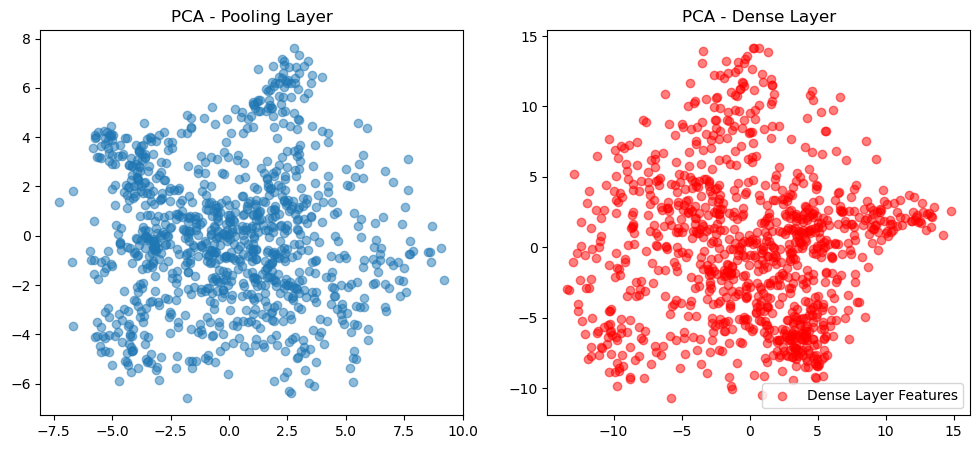

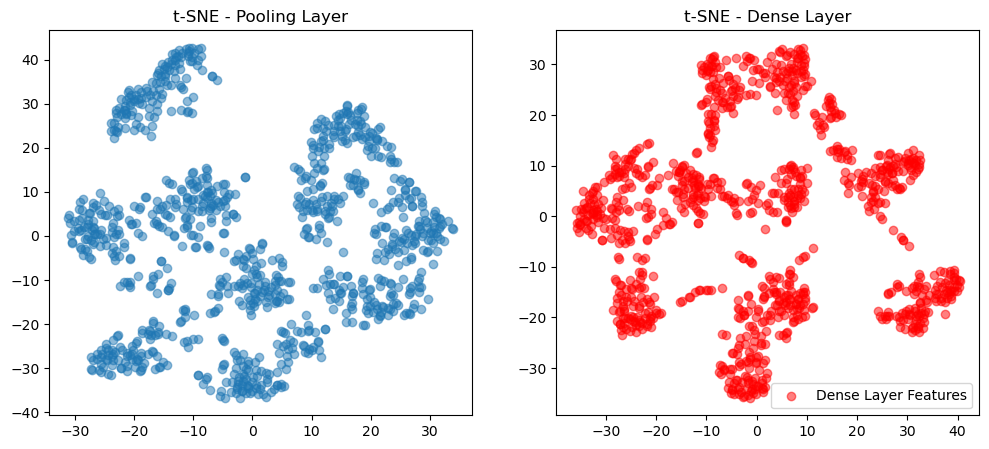

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Function to extract features from a given classifier layer
def extract_features(images, classifier, layer_name):

    feature_extractor = tf.keras.Model(classifier.input, classifier.get_layer("feature_extractor").output)
    features = feature_extractor.predict(images)
    return features.reshape(features.shape[0], -1)  # Flatten if necessary

# Extract features
features_pool = extract_features(loaded_images, classifier_pool, 'feature_extractor')
features_dense = extract_features(loaded_images, classifier_dense, 'feature_extractor')

# Apply PCA to reduce dimensions to 2
pca = PCA(n_components=2)
features_pool_pca = pca.fit_transform(features_pool)
features_dense_pca = pca.fit_transform(features_dense)

# Apply t-SNE for another visualization
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
features_pool_tsne = tsne.fit_transform(features_pool)
features_dense_tsne = tsne.fit_transform(features_dense)

# Plot PCA results
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].scatter(features_pool_pca[:, 0], features_pool_pca[:, 1], alpha=0.5, label='Pooling Layer Features')
axes[1].scatter(features_dense_pca[:, 0], features_dense_pca[:, 1], alpha=0.5, label='Dense Layer Features', color='r')
axes[0].set_title('PCA - Pooling Layer')
axes[1].set_title('PCA - Dense Layer')
plt.legend()
plt.show()

# Plot t-SNE results
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].scatter(features_pool_tsne[:, 0], features_pool_tsne[:, 1], alpha=0.5, label='Pooling Layer Features')
axes[1].scatter(features_dense_tsne[:, 0], features_dense_tsne[:, 1], alpha=0.5, label='Dense Layer Features', color='r')
axes[0].set_title('t-SNE - Pooling Layer')
axes[1].set_title('t-SNE - Dense Layer')
plt.legend()
plt.show()


# Note to plot above: 
The t-SNE plot for the Dense layer shows, at least for the mnist dataset, a better seperation between the 10 classes of data. 